# Wind Turbine Power Production
###  Project assessment
#### [Machine Learning and Statistics Module GMIT 2020 ]

---

<img align="left" width="300" src="https://image.flaticon.com/icons/png/512/1778/1778210.png">
<br>

<br>

Lecturer: *Ian McLoughlin (https://github.com/ianmcloughlin)*

Completed by: *Olga Rozhdestvina (G00387844@gmit.ie)*

---

## Table of Contents

* [Overview](#overview)
* [General Setup](#setup)
* [Reading the Data and Performing Basic Data Checks](#loading_data)
* [Data Preprocessing](#preproccesing)
    * [Outliers](#outliers)
    * [Creating Arrays for the Speed and the Power Variable](#arrays)
    * [Scaling](#scale)
    * [Creating the Training and Test Data sets](#split)
* [Build, Predict, and Evaluate the Models](#models)
    * [Linear Regression with Polynomial Features](#lr)
    * [Decision Tree](#dtree)
    * [Neural Networks](#nn)

<br>

### Overview. <a name="overview"></a>
___

Wind turbine power output is known for having a strong correlation with wind speed. In this work, three models were built for predicting the turbine response for a given wind speed: Linear Regression with Polynomial Features [1] and Decision Tree using [scikit-learn](https://scikit-learn.org/stable/) [2], and Neural Networks using [Tensorflow Keras](https://www.tensorflow.org/api_docs/python/tf/keras) [3]. The notebook also includes an analysis of a data set **powerproduction** and its preprocessing. 

The performance evaluation of the models is conducted using two metrics - [R-squared regression score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.r2_score.html) and [Root Mean Squared Error (RMSE)](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html). The indicators of a good model are low RMSE and high R-squared regression score. [4]

> [1] [Polynomial interpolation](https://scikit-learn.org/stable/auto_examples/linear_model/plot_polynomial_interpolation.html#sphx-glr-auto-examples-linear-model-plot-polynomial-interpolation-py)
<br>
[2] [Decision Trees](https://scikit-learn.org/stable/modules/tree.html)
<br>
[3] [tf.keras.Model](https://www.tensorflow.org/api_docs/python/tf/keras/Model)
<br>
[4] [Metrics and scoring: quantifying the quality of predictions](https://scikit-learn.org/stable/modules/model_evaluation.html)

<br>

### General Setup. <a name="setup"></a>
___

In [1]:
# Models.
import tensorflow.keras as kr
import sklearn.linear_model as md
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeRegressor

# Preprocessing.
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PolynomialFeatures

# Evaluation.
from sklearn.metrics import r2_score, mean_squared_error, explained_variance_score

# Numerical arrays.
import numpy as np

# Data frame.
import pandas as pd

# Plotting.
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
# Theme for plots.
plt.style.use('ggplot')
plt.rcParams["figure.titlesize"] = 18

# Plot size.
plt.rcParams['figure.figsize'] = [14, 8]

<br>

### Reading the Data and Performing Basic Data Checks. <a name="loading_data"></a>
___


In [3]:
# Load the iris data set from a URL.
df = pd.read_csv("powerproduction.csv")

# Display the data frame.
df

,speed,power
0,0.000,0.0
1,0.125,0.0
2,0.150,0.0
3,0.225,0.0
4,0.275,0.0
...,...,...
495,24.775,0.0
496,24.850,0.0
497,24.875,0.0
498,24.950,0.0


The data set has 500 rows and 2 columns with two numerical variables **speed** and **power** that are represented by real numbers. there are no empty values in the data set.

In [4]:
# Generate descriptive statistics.
df.describe()

,speed,power
count,500.000000,500.000000
mean,12.590398,48.014584
std,7.224991,41.614572
min,0.000000,0.000000
25%,6.324750,5.288000
50%,12.550500,41.645500
75%,18.775250,93.537000
max,25.000000,113.556000


The mean speed is 12.59, while the mean power stands at 48.01. Moreover, there is a difference in scale of the variables: speed has a range between 0.00 to 25.00 and power - between 0.00 and 113.556. This difference will be addressed in the preprocessing.

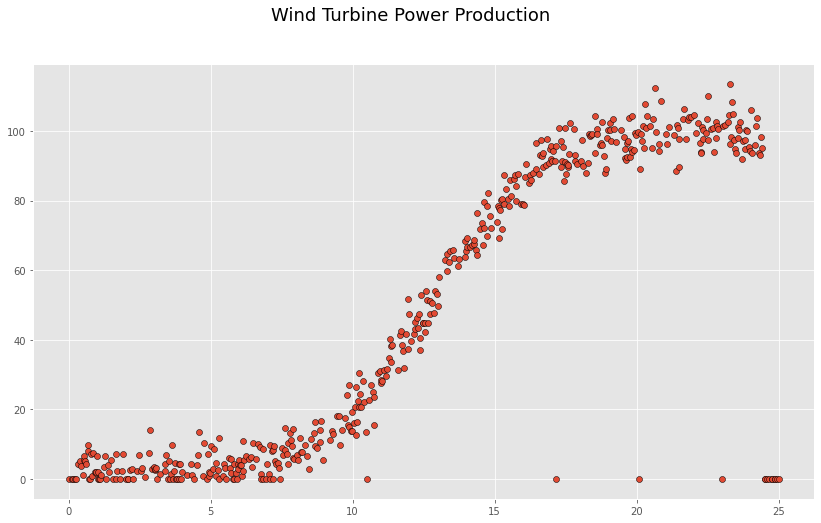

In [5]:
# Create a figure. axis and title.
fig,ax = plt.subplots()
fig.suptitle("Wind Turbine Power Production")

# Plot data.
ax.scatter(df.speed, df.power,edgecolor="black")

# Show the plot.
plt.show()

The above plot shows that the data follows a polynomial regression. The relationship between Power and Speed predominantly take "S"-shape. The power rises dramatically with speed over about 8 m/s and slows when the speed reaches about 17 m/s.

Additionally, we can see some outliers where the speed is above 5 m/s, however, the power is still 0.

<br>

###  Data Preprocessing. <a name="preproccesing"></a>
___

Prior to building models the data should undergo data preprocessing. 

There are 4 steps:
* Removing Outliers
* Creating arrays for the speed and the power.
* Scaling to account for the difference in scale of the variables.
* Creating the training and test data sets.

#### 1. Removing Outliers.  <a name="outliers"></a>
The first step is to remove the outliers from our data set. [5]

> [5] [Delete rows based on multiple conditions; including other column conditionals](https://stackoverflow.com/questions/31997992/delete-rows-based-on-multiple-conditions-including-other-column-conditionals)

In [6]:
# Remove Outliers.
df_new = df.drop(df[(df.power == 0) & (df.speed > 5)].index)

# Display cleaned data set.
df_new

,speed,power
0,0.000,0.000
1,0.125,0.000
2,0.150,0.000
3,0.225,0.000
4,0.275,0.000
...,...,...
485,24.249,103.700
486,24.299,93.694
487,24.349,93.078
488,24.374,98.223


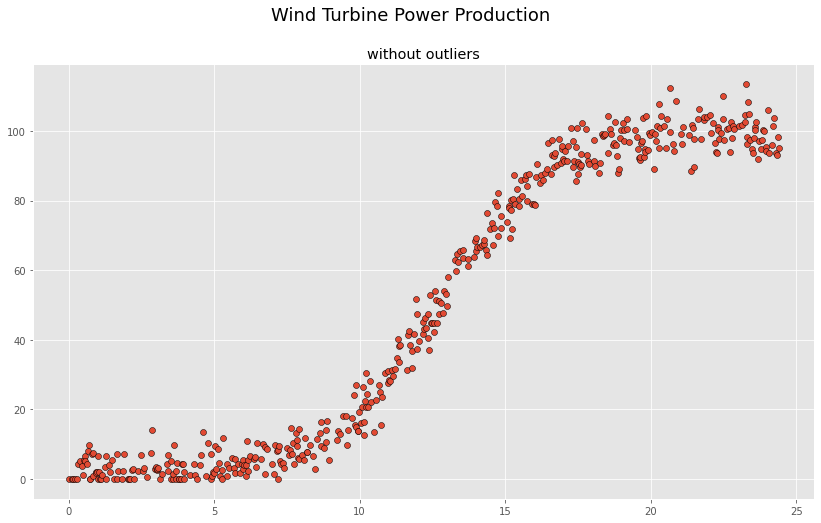

In [7]:
# Create a figure. axis and title.
fig,ax = plt.subplots()
fig.suptitle("Wind Turbine Power Production")
ax.set_title("without outliers")

# Plot data.
ax.scatter(df_new.speed, df_new.power,edgecolor="black")


# Show the plot.
plt.show()

<br>

#### 2. Creating Arrays for the Speed and the Power Variable.  <a name="arrays"></a>

Now the data set should be separated for speed and power values. 

In [8]:
# Separate speed and power.
speed = df_new.iloc[:, 0].values
power = df_new.iloc[:, 1].values

# Convert them into a numpy array and reshape.
X = np.array(speed).reshape(-1,1)
y = np.array(power).reshape(-1,1)

<br>

#### 3. Scaling. <a name="scale"></a>
Next we can scale the variables. By comparing different scalers I reached a conclusion that the best results are achieved with MinMaxScaler. [6]

[6] [Compare the effect of different scalers on data with outliers](https://scikit-learn.org/stable/auto_examples/preprocessing/plot_all_scaling.html)

In [9]:
# Create a instance of a scaler.
scaler = MinMaxScaler()

# Scale training and test data.
X = scaler.fit_transform(X)
y = scaler.fit_transform(y)

<br>

#### 4. Creating the Training and Test Data sets.  <a name="split"></a>

We will build our model on the training set and evaluate its performance on the test set. 

In [10]:
# Split data on training and test (add random state so the outputs are the same after each execution).
speed_train, speed_test, power_train, power_test = train_test_split(X, y, test_size=0.3, random_state=1)

# Print shape of sets.
print(f"Training set: {speed_train.shape}, {power_train.shape}")
print(f"Test set: {speed_test.shape}, {power_test.shape}")

Training set: (333, 1), (333, 1)
Test set: (144, 1), (144, 1)


<br>

### Build, Predict, and Evaluate the Models. <a name="models"></a>

<br>

#### Linear Regression with Polynomial Features.  <a name="lr"></a>
___

This model demonstrates how to approximate a function with a polynomial of degree *n* by using linear regression.

<br>

_Model Building._

The first step to building the model is applying polynomial features. In oder to do so we need to find the best fitting degree. [7] [8]
>[7] [How to Use Polynomial Feature Transforms for Machine Learning](https://machinelearningmastery.com/polynomial-features-transforms-for-machine-learning/)
<br>
[8] [How to sort with lambda in Python](https://stackoverflow.com/questions/3766633/how-to-sort-with-lambda-in-python)

In [11]:
# Find the best degree.
degrees = []

for degree in range(1,30):
    # Create a pipeline.
    pipeline = make_pipeline(PolynomialFeatures(degree), md.LinearRegression())
    # Fit it to the training data.
    pipeline.fit(speed_train, power_train)
    # Append score.
    degrees.append((degree, pipeline.score(speed_test,power_test)))

# Sort scores in the reverse order by the score. 
degrees.sort(key=lambda x:float(x[1]), reverse=True)

# Return only first 5 results.
for j in degrees[:5]:
    # Print results.
    print(f'{j}')

(22, 0.9906276015761861)
(23, 0.9906235363698063)
(21, 0.9906223734396851)
(24, 0.9906089040972884)
(25, 0.9905840147315644)


<br>
The results found that the degree 22 scores the best. 

In [12]:
# Create a pipeline with 22 degrees.
pipeline = make_pipeline(PolynomialFeatures(22), md.LinearRegression())

# Fit the model on the training data.
pipeline.fit(speed_train, power_train)

Pipeline(steps=[('polynomialfeatures', PolynomialFeatures(degree=22)),
                ('linearregression', LinearRegression())])

<br>

_Prediction_

Now that we have the model created, we can make predictions on the training and test data and plot them along with the actual data.

In [13]:
# Predict power from traint and test speed.
y_train_pred = pipeline.predict(speed_train)
y_test_pred = pipeline.predict(speed_test)

To view the results the rescaled power needs to be transformed back. [8] [9] For comparison of the actual and predicted power I randomly chose the 3rd row from training power and 5th from test power.

> [8] [scikit-learn: how to scale back the 'y' predicted result](https://stackoverflow.com/questions/38058774/scikit-learn-how-to-scale-back-the-y-predicted-result)
<br>
[9] [GeeksForGeeks: Remove square brackets from list](https://www.geeksforgeeks.org/python-remove-square-brackets-from-list/)

In [14]:
# Unscaling of power.
power_train_unscaled = str(scaler.inverse_transform(power_train)[3])[1:-1] 
power_test_unscaled = str(scaler.inverse_transform(power_test)[5])[1:-1] 

# Printing actual and predicted training power.
print(f"TRAINING DATA\nActual power:\t {power_train_unscaled}")
print(f"Predicted power: {str(scaler.inverse_transform(y_train_pred)[3])[1:-1]}")

# Printing actual and predicted test power.
print(f"\nTEST DATA\nActual power:\t {power_test_unscaled}")
print(f"Predicted power: {str(scaler.inverse_transform(y_test_pred)[5])[1:-1]}")

TRAINING DATA
Actual power:	 20.704
Predicted power: 20.78442233

TEST DATA
Actual power:	 99.09
Predicted power: 96.35120033


The above shows slight overestimation of training power and underestimation of test power for the chosen samples.

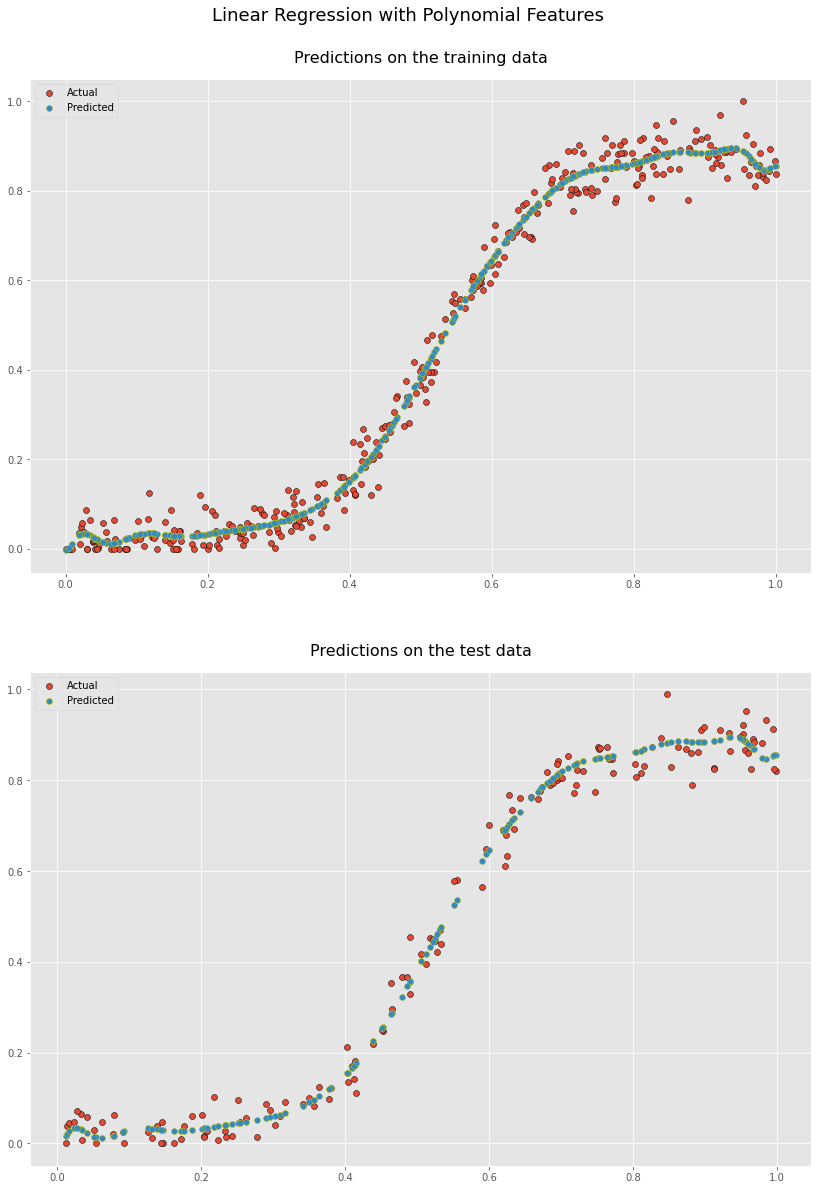

In [15]:
# Create a figure, axis and titles.
fig, [ax1,ax2] = plt.subplots(2,1, figsize=(14,20))
fig.suptitle("Linear Regression with Polynomial Features", y = 0.93)
ax1.set_title("Predictions on the training data",y=1.02, fontsize=16)
ax2.set_title("Predictions on the test data",y=1.02, fontsize=16)

# Plot actual training data and predictions.
ax1.scatter(speed_train, power_train,edgecolor="black",  label="Actual")
ax1.scatter(speed_train, y_train_pred, edgecolor="y", label="Predicted")

# Plot actual test data and predictions.
ax2.scatter(speed_test, power_test, edgecolor="black", label="Actual")
ax2.scatter(speed_test, y_test_pred, edgecolor="y", label="Predicted")

# Show legend.
ax1.legend(loc='upper left')
ax2.legend(loc='upper left')

# Show the plot.
plt.show()

The predicted data appears to be well-fitting to the actual data, however, evaluation of the model is required to confirm this.

<br> 

_Evaluation_

Let's calculate RMSE and R-squared score.

In [16]:
# Calculate a score and RMSE.
print("TRAINING DATA\nRMSE: \t\t", mean_squared_error(power_train,y_train_pred, squared=False))
print("R-squared Score:", r2_score(power_train, y_train_pred))

print("\nTEST DATA\nRMSE: \t\t", mean_squared_error(power_test,y_test_pred, squared=False))
print("R-squared Score:", r2_score(power_test,y_test_pred))

TRAINING DATA
RMSE: 		 0.03493901154771126
R-squared Score: 0.9906848033663184

TEST DATA
RMSE: 		 0.03504919109569987
R-squared Score: 0.9906276015761861


The result of computing the metrics confirm a high accuracy of the model. 

<br>

#### Decision Tree.  <a name="dtree"></a>
___

The decision tree model approximates a sigmoid curve through a set of if-then-else decision rules. The complexity of the rules and how well the model fits the data depends on maximum depth. 

<br>

_Model Building._

Following the same steps as in the previous model, first we need to determine the best maximum depth for the decision tree.[9]

> [9] [Non-Linear Regression Trees with scikit-learn](https://www.pluralsight.com/guides/non-linear-regression-trees-scikit-learn)

In [17]:
# Finding the best max_depth
depth = []

# Find the best depth.
for d in range(1,30):

    # Create a decision tree and fit it.
    df = DecisionTreeRegressor(max_depth=d, random_state=1)
    # Fit it to the train data.
    df.fit(speed_train, power_train)
    
    # Predict train and test speed.
    pred_train_tree= df.predict(speed_train)
    pred_test_tree = df.predict(speed_test)
    
    # Append stats to the list.
    depth.append((d, np.sqrt(mean_squared_error(power_train,pred_train_tree)),
                    r2_score(power_train, pred_train_tree),
                    np.sqrt(mean_squared_error(power_test,pred_test_tree)),
                    r2_score(power_test, pred_test_tree)))

# Sort the list in the reverse order by the score of test data. 
depth.sort(key=lambda x:float(x[4]), reverse=True)

# Return only first 5 results.
for j in depth[:5]:
    # Print results.
    print(f'Depth {j[0]}: {j[1:5]}')

Depth 5: (0.031321656108007856, 0.9925138205692745, 0.037984434082453576, 0.9889920597267922)
Depth 6: (0.0279944909801426, 0.9940197966955947, 0.03944660784875181, 0.9881282684085648)
Depth 4: (0.033649256667017055, 0.9913598407359276, 0.03978134876031001, 0.9879259282932045)
Depth 7: (0.025112189616395397, 0.9951878410708414, 0.04121827421183461, 0.9870379303120649)
Depth 8: (0.02160732660105462, 0.9964373523587261, 0.044231755883705544, 0.9850733240763359)


Thus, 5 is the optimal maximum depth for our data.

In [18]:
# Create a decision tree.
dtree = DecisionTreeRegressor(max_depth=5, random_state=1)
dtree.fit(speed_train, power_train)

DecisionTreeRegressor(max_depth=5, random_state=1)

<br> 

_Prediction_


In [19]:
# Predict train and test speed.
pred_train_tree = dtree.predict(speed_train)
pred_test_tree = dtree.predict(speed_test)

In [20]:
# Unscaling of power.
unscaled_train_tree = str(scaler.inverse_transform(pred_train_tree.reshape(-1,1))[3])[1:-1] 
unscaled_test_tree  = str(scaler.inverse_transform(pred_test_tree.reshape(-1,1))[5])[1:-1]

# Printing actual and predicted training power.
print(f"TRAINING DATA\nActual power:\t {power_train_unscaled}")
print(f"Predicted power: {unscaled_train_tree}")

# Printing actual and predicted test power.
print(f"\nTEST DATA\nActual power:\t {power_test_unscaled}")
print(f"Predicted power: {unscaled_test_tree}")

TRAINING DATA
Actual power:	 20.704
Predicted power: 23.50855556

TEST DATA
Actual power:	 99.09
Predicted power: 91.87883333


Here we can see higher degree of overestimation of training power and underestimation of test power for the chosen samples than in the Linear Model with Polynomial Features.

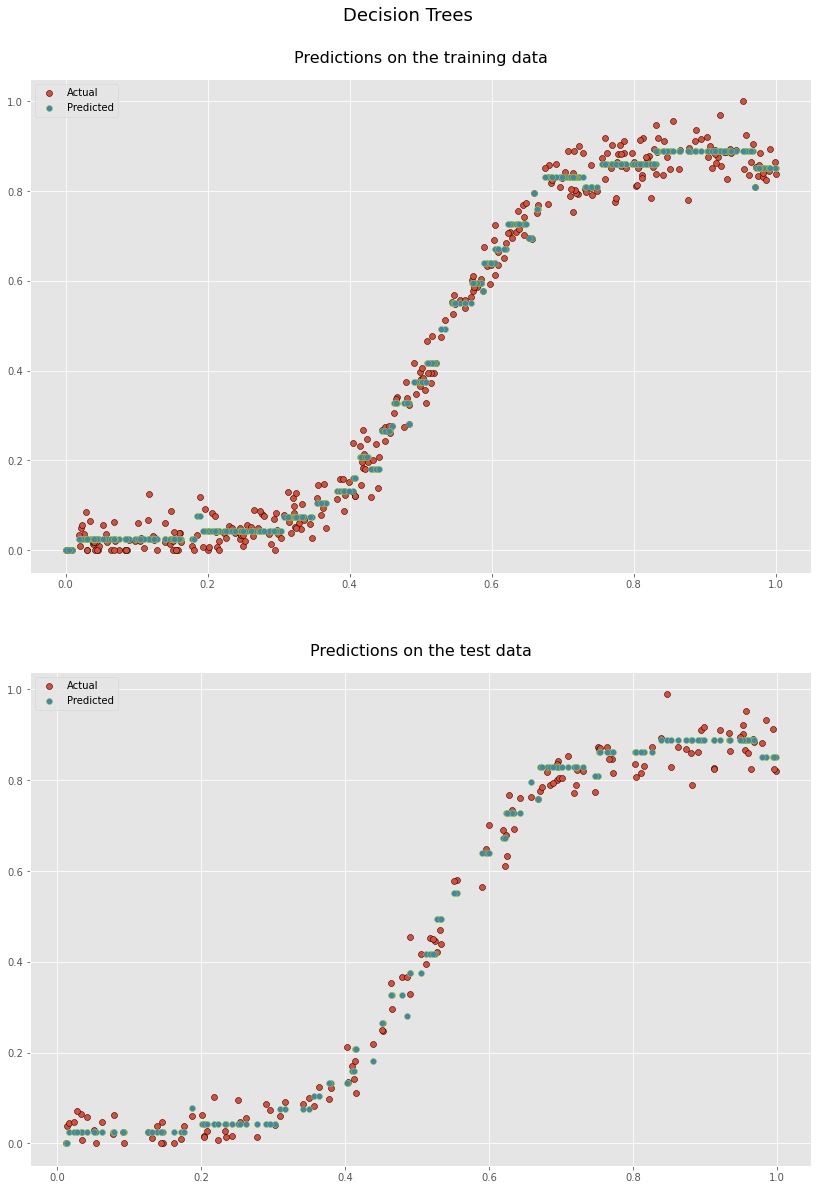

In [21]:
# Create a figure, axis and titles.
fig, [ax1,ax2] = plt.subplots(2,1, figsize=(14,20))
fig.suptitle("Decision Trees", y=0.93)
ax1.set_title("Predictions on the training data",y=1.02, fontsize=16)
ax2.set_title("Predictions on the test data",y=1.02, fontsize=16)

# Plot actual training data and predictions.
ax1.scatter(speed_train, power_train, edgecolor="black", label="Actual")
ax1.scatter(speed_train, pred_train_tree, edgecolor="y", label="Predicted")

# Plot actual test data and predictions.
ax2.scatter(speed_test, power_test, edgecolor="black", label="Actual")
ax2.scatter(speed_test, pred_test_tree, edgecolor="y", label="Predicted")

# Show legend.
ax1.legend(loc='upper left')
ax2.legend(loc='upper left')

# Show the plot.
plt.show()

The plots show quite a different result from the previous model - the predicted data points appear to gather into multiple horizontal lines. Despite that the predicted data here too seems to fit the actual data well.

<br> 

_Evaluation_

In [22]:
# Calculate a score and RMSE.
print("TRAINING DATA\nRMSE: \t\t", mean_squared_error(power_train,pred_train_tree, squared=False))
print("R-squared Score:", r2_score(power_train, pred_train_tree))
print("\nTEST DATA\nRMSE: \t\t", mean_squared_error(power_test,pred_test_tree, squared=False))
print("R-squared Score:", r2_score(power_test, pred_test_tree))

TRAINING DATA
RMSE: 		 0.031321656108007856
R-squared Score: 0.9925138205692745

TEST DATA
RMSE: 		 0.037984434082453576
R-squared Score: 0.9889920597267922


The above determines that the Decision tree model predicts the training data better than the Linear Model. However, it underperforms the previous model when it comes to predicting the test data.

<br>

#### Neural Networks.  <a name="nn"></a>
___


Neural networks model works by identifying underlying relationships in the data set. 

<br>

_Model Building._

First for enhancement of the future model the Polynomial Features are applied. Earlier it was determined that the best score was achieved with 22 degrees. [10]

> [10] [Polynomial Regression using tf.keras](https://medium.com/@anigasan637/polynomial-regression-using-tf-keras-17eaac771256)

In [23]:
# Apply polynomial features to speed data.
poly = PolynomialFeatures(22)
speed_train = poly.fit_transform(speed_train)
speed_test = poly.fit_transform(speed_test)

# Input shape.
speed_train.shape

(333, 23)

Now that the data is ready, we can train and compile our neural networks model. In our training data set, the input is now of 23 values and output is of 1 value. Thus, the input and output layer is of 23 and 1 dimensions respectively.

The model has 3 hidden layers: the first two with relu activation and the last with linear. To get reproducible results I have specified the seed for each kernel initializer. [11] In the model compilation I changed the learning rate for the optimizer from default to 0.01.

> [11] [How to get reproducible result when running Keras with Tensorflow backend](https://stackoverflow.com/questions/45230448/how-to-get-reproducible-result-when-running-keras-with-tensorflow-backend)

In [24]:
# Train a different model.
model = kr.models.Sequential()
model.add(kr.layers.Dense(55, input_shape=(23,), activation='relu', kernel_initializer=kr.initializers.RandomUniform(seed=1)))
model.add(kr.layers.Dense(15, input_shape=(23,), activation='relu', kernel_initializer=kr.initializers.he_uniform(seed=1)))
model.add(kr.layers.Dense(1, activation='linear', kernel_initializer=kr.initializers.RandomUniform(seed=1)))

# Compile the model.
model.compile(optimizer=kr.optimizers.Adam(0.01), loss='mse')

After building and compiling the model, we can fit it to the training data and validate it by the test data. [12]

> [12] [How to Control the Stability of Training Neural Networks With the Batch Size](https://machinelearningmastery.com/how-to-control-the-speed-and-stability-of-training-neural-networks-with-gradient-descent-batch-size/)

In [25]:
# Fit the model to the training data (hide the output).
model.fit(speed_train, power_train, epochs=380, batch_size=len(speed_train), verbose=False, validation_data=(speed_test, power_test))

<br>

_Prediction_


In [26]:
# Predict power for train and test data.
y_nn_train = model.predict(speed_train)
y_nn_test = model.predict(speed_test)

In [27]:
# Unscaling of power.
unscaled_train_nn = str(scaler.inverse_transform(y_nn_train.reshape(-1,1))[3])[1:-1] 
unscaled_test_nn = str(scaler.inverse_transform(y_nn_test.reshape(-1,1))[5])[1:-1]

# Printing actual and predicted training power.
print(f"TRAINING DATA\nActual power:\t {power_train_unscaled}")
print(f"Predicted power: {unscaled_train_nn}")

# Printing actual and predicted test power.
print(f"\nTEST DATA\nActual power:\t {power_test_unscaled}")
print(f"Predicted power: {unscaled_test_nn}")

TRAINING DATA
Actual power:	 20.704
Predicted power: 21.407719

TEST DATA
Actual power:	 99.09
Predicted power: 95.62335


The above shows results somewhat between the previous two models. The model also shows tendency for overestimation of training power and underestimation of test power for the chosen samples. 

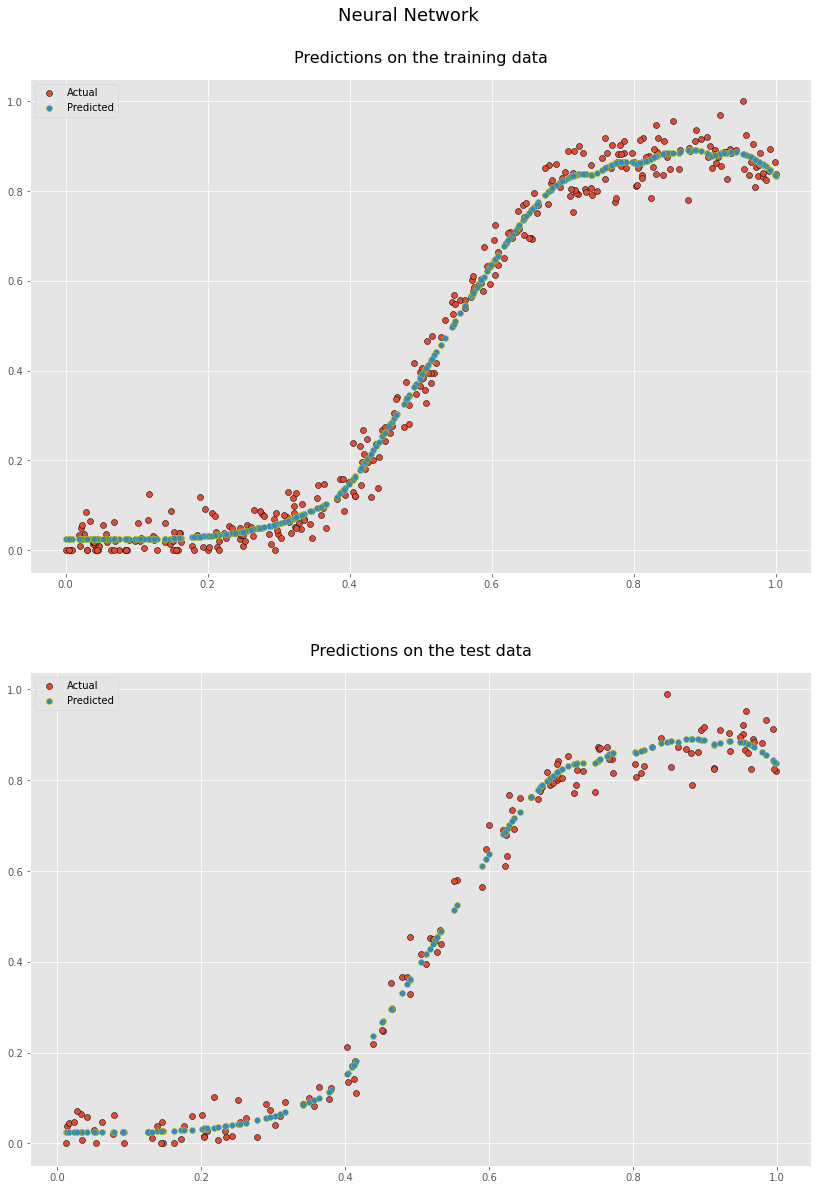

In [28]:
# Create a figure, axis and titles.
fig, [ax1,ax2] = plt.subplots(2,1, figsize=(14,20))
fig.suptitle("Neural Network", y=0.93)
ax1.set_title("Predictions on the training data",y=1.02, fontsize=16)
ax2.set_title("Predictions on the test data",y=1.02, fontsize=16)

# Plot actual training data and predictions.
ax1.scatter(speed_train[:, 1], power_train, edgecolor="black", label="Actual")
ax1.scatter(speed_train[:, 1], y_nn_train, edgecolor="y", label="Predicted")

# Plot actual test data and predictions.
ax2.scatter(speed_test[:, 1], power_test, edgecolor="black", label="Actual")
ax2.scatter(speed_test[:, 1], y_nn_test, edgecolor="y", label="Predicted")

# Show legend.
ax1.legend(loc='upper left')
ax2.legend(loc='upper left')

# Show the plot.
plt.show()

Once again, the plots depict well-fitting predicted data. 

<br> 

_Evaluation_

In [29]:
# Calculate a score and RMSE.
print("TRAINING DATA\nRMSE: \t\t", mean_squared_error(power_train,y_nn_train, squared=False))
print("R-squared Score:", r2_score(power_train, y_nn_train))

print("\nTEST DATA\nRMSE: \t\t", mean_squared_error(power_test,y_nn_test, squared=False))
print("R-squared Score:", r2_score(power_test,y_nn_test))

TRAINING DATA
RMSE: 		 0.03527291634686386
R-squared Score: 0.9905059058309096

TEST DATA
RMSE: 		 0.03470069960403231
R-squared Score: 0.9908130531206399


While the performance of the Neural Network model is slightly worse than Decision Tree and Linear Regression with Polynomial Features models in predicting of training data, it is the best of all three in predicting the test data.

<br>

### Conclusion.

___

___

<br>

### End.